In [8]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='../../data', name='Cora')

data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/nfs/homedirs/gosl/miniconda3/envs/py397/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/nfs/homedirs/gosl/miniconda3/envs/py397/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


# Average Degrees

In [12]:
# Counts all edges twice!
n_intra_edges = 0
n_inter_edges = 0
n = data.num_nodes
for n1, n2 in zip(data.edge_index[0], data.edge_index[1]):
    if data.y[n1] == data.y[n2]:
        n_intra_edges += 1
    else:
        n_inter_edges += 1
print(f"Average #edges per node: {(n_intra_edges + n_inter_edges)/n}")
print(f"Average intra-connections: {n_intra_edges / n}")
print(f"Average inter-connections: {n_inter_edges / n}")

Average #edges per node: 3.8980797636632203
Average intra-connections: 3.157311669128508
Average inter-connections: 0.7407680945347119


In [14]:
# Count edges onces
A_sparse = torch.sparse_coo_tensor(data.edge_index, [1 for i in range(data.num_edges)])
A = A_sparse.to_dense()
n = data.num_nodes
n_intra_edges = 0
n_inter_edges = 0
for i in range(n):
    for j in range(i+1, n):
        if data.y[i] == data.y[j]:
            if A[i,j] == 1:
                 n_intra_edges += 1
        else:
            if A[i,j] == 1:
                 n_inter_edges += 1
print(f"Number of edges: {n_intra_edges + n_inter_edges}")
print(f"Average #edges per node: {(n_intra_edges + n_inter_edges)/n}")
print(f"Average intra-connections per node: {n_intra_edges / n}")
print(f"Average inter-connections per node: {n_inter_edges / n}")

Number of edges: 5278
Average #edges per node: 1.9490398818316101
Average intra-connections: 1.578655834564254
Average inter-connections: 0.37038404726735596


Average Degree: 3.8980797636632203


(0.0, 15.0)

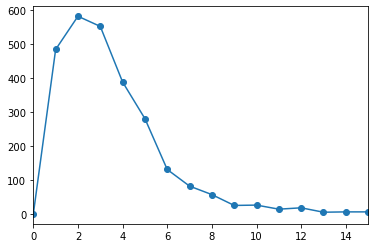

In [11]:
deg = torch.sum(A, dim=1).cpu().numpy()
print(f"Average Degree: {np.sum(deg) / deg.shape[0]}")
max_deg = np.max(deg)
c = Counter(deg)
ordered_c = [c[i] if i in c else 0 for i in range(max_deg+1)]
fig, axs = plt.subplots(1, 1)
axs.plot(range(len(ordered_c)), ordered_c, 'o-')
axs.set_xlim(left=0, right=15)


In [2]:
print(data.edge_index.shape)

torch.Size([2, 10556])
